# LAB06 Convolutional Neural Network (CNN)


```
11 Octorber 2024
Introduction to Machine Learning
```



### Google Drive Authentication

In [ ]:
# Access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigation to Dataset Folder
%cd drive/MyDrive/ # your_folder_path

### Import Library

In [ ]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory

### CPUs Available?

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

print( 'Tensorflow Version:', tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow Version: 2.17.0
Num GPUs Available:  1


### Read Data

In [ ]:
_base_dir = 'your_folder_path/'

In [ ]:
print(os.listdir(_base_dir))

['normal', 'positive']


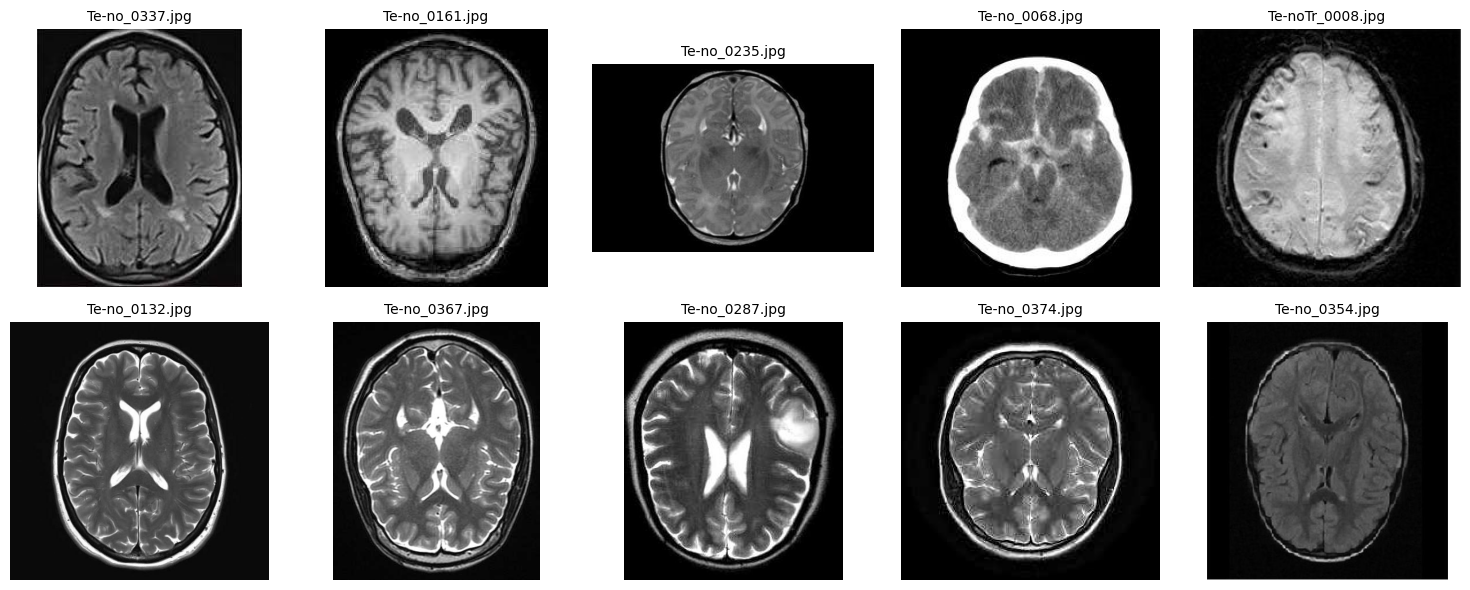

In [ ]:
# Define the path to the folder containing images
image_folder = os.path.join(_base_dir, 'normal')
image_files = os.listdir(image_folder)

# Shuffle the list of images to randomize the order
random.shuffle(image_files)

# Create a function to display images in a 5-column and 2-row grid
def display_images(image_folder, image_files):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i in range(10):  # Loop to display 10 images (2 rows * 5 columns)
        if i < len(image_files):  # Check if there are enough images
            img = Image.open(os.path.join(image_folder, image_files[i]))

            # Check if the image is grayscale or RGB
            if img.mode == 'L':
                axes[i].imshow(img, cmap='gray')
            else:
                axes[i].imshow(img)

            axes[i].set_title(image_files[i], fontsize=10)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Call the function to display the images
display_images(image_folder, image_files)

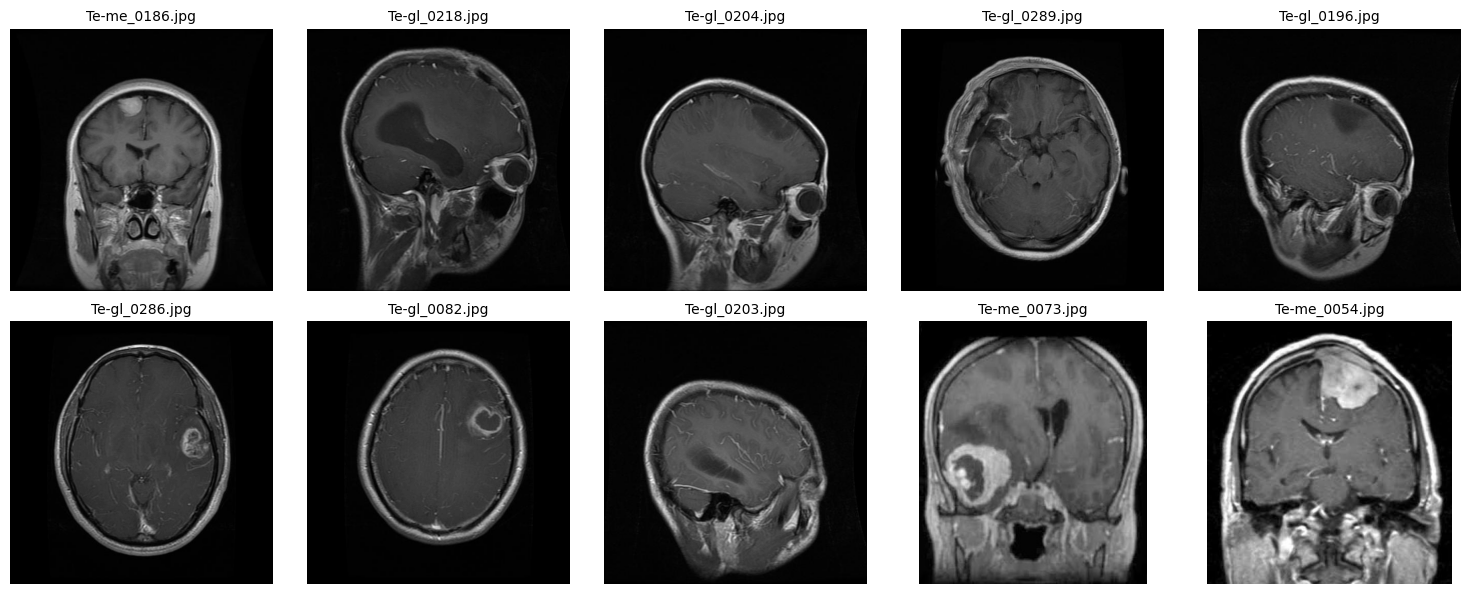

In [ ]:
# Define the path to the folder containing images
image_folder = os.path.join(_base_dir, 'positive')
image_files = os.listdir(image_folder)

# Shuffle the list of images to randomize the order
random.shuffle(image_files)

# Create a function to display images in a 5-column and 2-row grid
def display_images(image_folder, image_files):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i in range(10):  # Loop to display 10 images (2 rows * 5 columns)
        if i < len(image_files):  # Check if there are enough images
            img = Image.open(os.path.join(image_folder, image_files[i]))

            # Check if the image is grayscale or RGB
            if img.mode == 'L':  # 'L' mode is for grayscale images
                axes[i].imshow(img, cmap='gray')  # Display the grayscale image with cmap='gray'
            else:
                axes[i].imshow(img)  # Display RGB image normally

            axes[i].set_title(image_files[i], fontsize=10)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Call the function to display the images
display_images(image_folder, image_files)

### Prepare Data Directories

In [ ]:
# Define the base directory where your images are stored
_base_dir = 'your_folder_path'
categories = ['normal', 'positive']
split_ratios = {'train': 0.7, 'val': 0.15, 'test': 0.15}

# Define output directories for Train, Val, and Test sets
output_dirs = {
    'train': 'your_folder_path',
    'val': 'your_folder_path',
    'test': 'your_folder_path'
}

In [ ]:
# Function to create output directories and remove them if they already exist
def create_output_dirs(output_dirs, categories):
    for split_dir in output_dirs.values():
        # If the directory exists, remove it and create a new one
        if os.path.exists(split_dir):
            shutil.rmtree(split_dir)  # Remove the directory and all its contents
        os.makedirs(split_dir)  # Recreate the base split directory

        # Create subdirectories for each category (normal, positive)
        for category in categories:
            category_path = os.path.join(split_dir, category)
            os.makedirs(category_path)  # Create category directory

In [ ]:
# Remove and recreate the output directories
create_output_dirs(output_dirs, categories)

In [ ]:
# Function to split the data into train, validation, and test sets
def split_data(category, source_dir, output_dirs, split_ratios):
    # List all files in the source directory
    files = os.listdir(source_dir)
    # Shuffle the files randomly to ensure randomness
    random.shuffle(files)
    total_files = len(files)

    # Calculate the number of files for training, validation, and testing
    train_size = int(split_ratios['train'] * total_files)
    val_size = int(split_ratios['val'] * total_files)

    # Slice the file list into train, validation, and test sets
    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    # Copy files to their respective directories
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(output_dirs['train'], category))
    for file in val_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(output_dirs['val'], category))
    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(output_dirs['test'], category))

# Split the files for each category (normal, positive)
for category in categories:
    source_dir = os.path.join(_base_dir, category)
    split_data(category, source_dir, output_dirs, split_ratios)

print("Data split completed")

Data split completed


In [ ]:
base_dir = 'your_folder_path'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

### Image Preprocessing

In [ ]:
# Function to load images and labels
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299,299])
    image = image / 255.0  # Normalize to [0,1] range
    return image, label

# Function to prepare dataset
def prepare_dataset(image_paths, labels, batch_size):
    # Create TensorFlow Dataset from image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Load image paths and labels (assuming binary classification: 0 = normal, 1 = positive)
def load_data(directory):
    image_paths = []
    labels = []
    for label, category in enumerate(['normal', 'positive']):  # 0 = normal, 1 = positive
        category_dir = os.path.join(directory, category)
        for img_name in os.listdir(category_dir):
            image_paths.append(os.path.join(category_dir, img_name))
            labels.append(label)  # Assign label based on category
    return image_paths, labels

In [ ]:
# Load image paths and labels for train, val, and test sets
train_paths, train_labels = load_data(train_dir)
val_paths, val_labels = load_data(val_dir)
test_paths, test_labels = load_data(test_dir)

# Prepare datasets
batch_size = #NUM_BATCH_SIZE
train_dataset = prepare_dataset(train_paths, train_labels, batch_size)
val_dataset = prepare_dataset(val_paths, val_labels, batch_size)
test_dataset = prepare_dataset(test_paths, test_labels, batch_size)

### Model Initialization

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def model_init():

    # Select the model from https://keras.io/api/applications/#available-models
    base_model = InceptionV3(weights=None, include_top=False, input_shape=(299, 299, 3))

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=predictions)

    return base_model, model


In [ ]:
base_model, model = model_init()

# Freeze base model layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Training the Model

In [ ]:
num_epochs = # NUM_EPOCH
batch_size = # NUM_BATCH_SIZE

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs
)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 508ms/step - accuracy: 0.5807 - loss: 0.6751 - val_accuracy: 0.7785 - val_loss: 0.5187
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.7455 - loss: 0.5514 - val_accuracy: 0.7651 - val_loss: 0.5153
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.7385 - loss: 0.5339 - val_accuracy: 0.8054 - val_loss: 0.4735
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.7619 - loss: 0.5102 - val_accuracy: 0.7785 - val_loss: 0.4863
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7640 - loss: 0.5008 - val_accuracy: 0.8121 - val_loss: 0.4523
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8033 - loss: 0.4475 - val_accuracy: 0.8188 - val_loss: 0.4461
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.8052 - loss: 0.4301 - val_accuracy: 0.8121 - val_loss: 0.4385
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.7823 - loss: 0.4811 - val_acc

### Visualization of Training Results

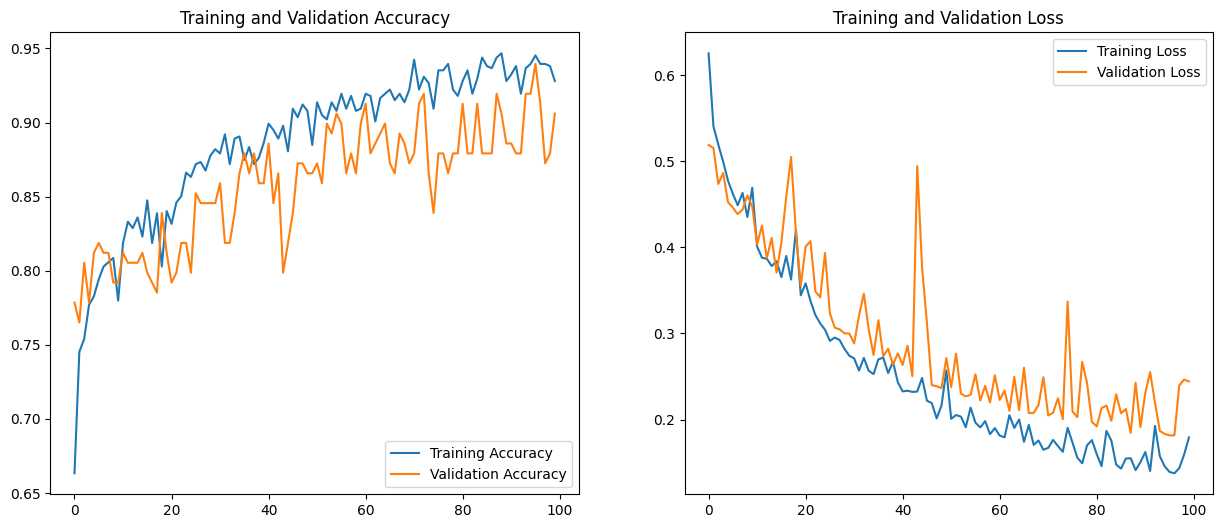

In [ ]:
# Plotting accuracy and loss curves
def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    # Plot Accuracy
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Visualize the results
plot_training_results(history)

### Prediction Model

In [ ]:
# Function to load and preprocess the image (resize and normalize)
def load_and_preprocess_image(image_path, target_size=(#IMGSIZE?, #IMGSIZE?)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Function to make a prediction using the trained model
def predict_image(model, image_path):
    # Load and preprocess the selected image
    img_array = load_and_preprocess_image(image_path)

    # Display the selected image
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Make the prediction
    prediction = model.predict(img_array)

    # Convert the result to a readable format
    if prediction[0] >= 0.5:
        result = 'Positive (Tumor)'
    else:
        result = 'Normal'

    # Print the prediction result with confidence score
    print(f"Prediction: {result} (Confidence: {prediction[0][0]:.4f})")

#### Normal Case

In [ ]:
print(os.listdir(os.path.join(test_dir, 'normal')))

['Te-no_0211.jpg', 'Te-no_0236.jpg', 'Te-no_0315.jpg', 'Te-noTr_0009.jpg', 'Te-no_0364.jpg', 'Te-no_0353.jpg', 'Te-no_0240.jpg', 'Te-no_0270.jpg', 'Te-no_0253.jpg', 'Te-no_0402.jpg', 'Te-no_0134.jpg', 'Te-no_0390.jpg', 'Te-no_0212.jpg', 'Te-no_0130.jpg', 'Te-no_0359.jpg', 'Te-no_0305.jpg', 'Te-no_0154.jpg', 'Te-noTr_0003.jpg', 'Te-no_0177.jpg', 'Te-no_0125.jpg', 'Te-no_0099.jpg', 'Te-no_0267.jpg', 'Te-no_0320.jpg', 'Te-no_0227.jpg', 'Te-no_0102.jpg', 'Te-no_0310.jpg', 'Te-no_0343.jpg', 'Te-no_0366.jpg', 'Te-no_0157.jpg', 'Te-no_0387.jpg', 'Te-no_0303.jpg', 'Te-no_0298.jpg', 'Te-no_0231.jpg', 'Te-no_0056.jpg', 'Te-no_0246.jpg', 'Te-no_0318.jpg', 'Te-no_0325.jpg', 'Te-no_0230.jpg', 'Te-no_0111.jpg', 'Te-no_0228.jpg', 'Te-no_0222.jpg', 'Te-no_0083.jpg', 'Te-no_0180.jpg', 'Te-no_0160.jpg', 'Te-no_0349.jpg', 'Te-no_0341.jpg', 'Te-no_0044.jpg', 'Te-no_0311.jpg', 'Te-no_0153.jpg', 'Te-no_0075.jpg', 'Te-no_0218.jpg', 'Te-no_0185.jpg', 'Te-no_0175.jpg', 'Te-no_0128.jpg', 'Te-no_0365.jpg', 'Te-n

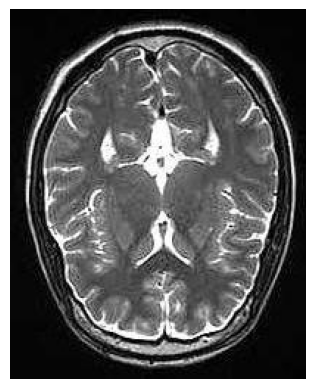

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction: Normal (Confidence: 0.0000)


In [ ]:
img_test_path = os.path.join(test_dir, 'normal', 'Te-no_0160.jpg')
predict_image(model, img_test_path)

#### Positive Case

In [ ]:
print(os.listdir(os.path.join(test_dir, 'positive')))

['Te-gl_0190.jpg', 'Te-gl_0046.jpg', 'Te-me_0160.jpg', 'Te-me_0175.jpg', 'Te-me_0114.jpg', 'Te-gl_0192.jpg', 'Te-me_0289.jpg', 'Te-gl_0174.jpg', 'Te-gl_0118.jpg', 'Te-me_0235.jpg', 'Te-me_0040.jpg', 'Te-me_0254.jpg', 'Te-gl_0088.jpg', 'Te-gl_0027.jpg', 'Te-me_0298.jpg', 'Te-gl_0052.jpg', 'Te-me_0295.jpg', 'Te-me_0192.jpg', 'Te-me_0279.jpg', 'Te-me_0177.jpg', 'Te-me_0210.jpg', 'Te-me_0195.jpg', 'Te-me_0139.jpg', 'Te-gl_0279.jpg', 'Te-me_0238.jpg', 'Te-me_0132.jpg', 'Te-gl_0024.jpg', 'Te-gl_0216.jpg', 'Te-gl_0291.jpg', 'Te-gl_0023.jpg', 'Te-me_0096.jpg', 'Te-meTr_0002.jpg', 'Te-gl_0173.jpg', 'Te-gl_0029.jpg', 'Te-me_0227.jpg', 'Te-me_0054.jpg', 'Te-gl_0199.jpg', 'Te-gl_0232.jpg', 'Te-gl_0286.jpg', 'Te-me_0215.jpg', 'Te-gl_0031.jpg', 'Te-me_0073.jpg', 'Te-gl_0220.jpg', 'Te-gl_0014.jpg', 'Te-me_0117.jpg', 'Te-gl_0290.jpg', 'Te-me_0131.jpg', 'Te-me_0143.jpg', 'Te-me_0194.jpg', 'Te-me_0220.jpg', 'Te-me_0149.jpg', 'Te-me_0304.jpg', 'Te-me_0120.jpg', 'Te-me_0176.jpg', 'Te-gl_0155.jpg', 'Te-me_

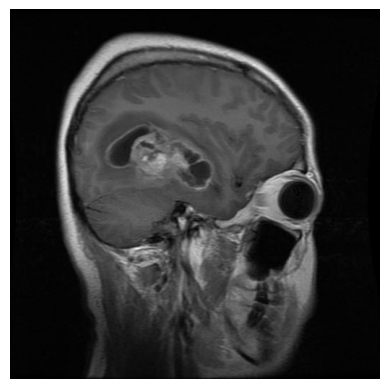

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction: Positive (Tumor) (Confidence: 0.9847)


In [ ]:
img_test_path = os.path.join(test_dir, 'positive', 'Te-gl_0282.jpg')
predict_image(model, img_test_path)

### Save Model

In [ ]:
# Save the model with a .keras extension
model.save('your_folder_path/your_model_name.keras')